In [1]:
####
# Creator;Maintainer: Tamas Szuromi - tromika@gmail.com
####

In [59]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lifetimes import BetaGeoFitter, ModifiedBetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data

In [2]:
data = pd.read_csv("../data/raw/training.csv")

In [3]:
data.columns.values

array(['order_id', 'contact_id', 'purchase_date', 'product_id', 'quantity',
       'sales_amount'], dtype=object)

In [26]:
data.dtypes

order_id                  int64
contact_id                int64
purchase_date    datetime64[ns]
product_id                int64
quantity                  int64
sales_amount            float64
dtype: object

In [4]:
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

In [27]:
data.head()

,order_id,contact_id,purchase_date,product_id,quantity,sales_amount
0,4852169,17846335,2012-01-01,3308032,1,18.71
1,3570597,18759585,2012-01-01,37220513,2,83.50
2,32096674,5025194,2012-01-01,10259603,1,19.95
3,2904402,29624779,2012-01-01,3308032,1,18.71
4,38369470,42287117,2012-01-01,3308032,1,18.71


In [102]:
from sklearn.cluster import KMeans
dataCopy = data[['quantity','sales_amount']]
outliersModel = KMeans(n_clusters=2)
outliersModelFit = outliersModel.fit(dataCopy)

In [107]:
dataClustered[dataClustered.cluster == 1][:10]


,quantity,sales_amount,cluster
8,1,239.95,1
36,1,324.28,1
37,1,321.43,1
47,1,195.95,1
60,1,207.95,1
62,1,199.95,1
105,1,297.00,1
139,4,199.60,1
149,1,233.95,1
173,1,199.95,1


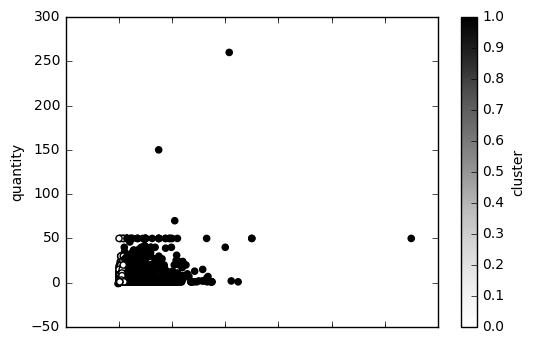

In [111]:
from matplotlib import pyplot
dataClustered.plot(kind='scatter', x='sales_amount', y='quantity', c='cluster')


In [ ]:
from sklearn import svm
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(dataCopy)

In [ ]:
clf.predict(dataCopy)

In [93]:
dataFiltered = data[data.sales_amount>0]
inputData = dataFiltered.groupby(['contact_id', 'order_id']).agg({'sales_amount': np.sum, 'purchase_date':'first'}).reset_index()

In [94]:
inputData.head()

,contact_id,order_id,purchase_date,sales_amount
0,22,20931901,2012-01-03,27.45
1,445,36058004,2012-11-22,131.85
2,665,15515069,2013-06-06,309.47
3,734,30699049,2013-05-07,69.90
4,884,2789595,2013-03-21,254.85


In [95]:
trainingSet = summary_data_from_transaction_data(inputData, 'contact_id', 'purchase_date', monetary_value_col= 'sales_amount', freq='M',observation_period_end='2013-12-31')

In [31]:
trainingSet.columns.values

array(['frequency', 'recency', 'T', 'monetary_value'], dtype=object)

In [97]:
bgf = ModifiedBetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(trainingSet['frequency'], trainingSet['recency'], trainingSet['T'])
print bgf

<lifetimes.ModifiedBetaGeoFitter: fitted with 262294 subjects, a: 0.81, alpha: 7.20, b: 0.68, r: 0.59>


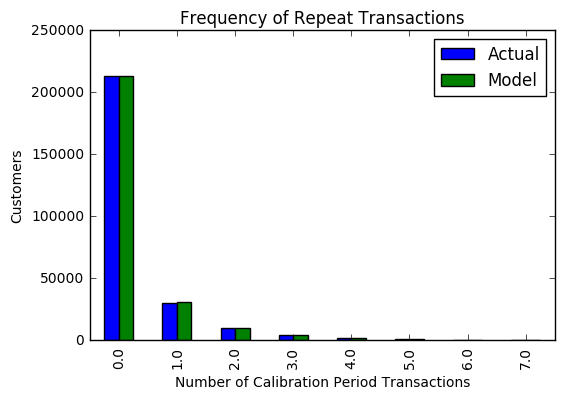

In [98]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

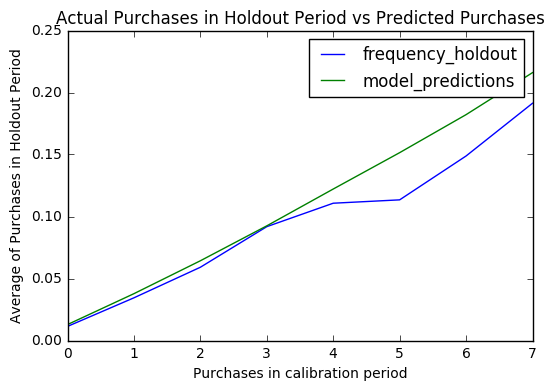

In [99]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(data, 'contact_id', 'purchase_date', 
                                        calibration_period_end='2013-11-30',
                                        observation_period_end='2013-12-31', 
                                        freq='M' )   
bgfVal = ModifiedBetaGeoFitter(penalizer_coef=0.0001)
bgfVal.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgfVal, summary_cal_holdout)

In [100]:
from lifetimes import GammaGammaFitter

ReturningtTrainingSet = trainingSet[trainingSet['frequency']>0]
ggf = GammaGammaFitter(penalizer_coef = 0.0001)
ggf.fit(ReturningtTrainingSet['frequency'],
        ReturningtTrainingSet['monetary_value'])
print ggf  

<lifetimes.GammaGammaFitter: fitted with 49158 subjects, p: 8.00, q: 1.87, v: 11.84>


In [101]:
print "Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        trainingSet['frequency'],
        trainingSet['monetary_value']
    ).mean(),
    trainingSet[trainingSet['frequency']>0]['monetary_value'].mean()
)

Expected conditional average profit: 106.802220854, Average profit: 95.773102981


In [102]:
trainingSet['monetary_value'].mean()

17.94937816473854

In [103]:

pred = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    trainingSet['frequency'],
    trainingSet['recency'],
    trainingSet['T'],
    trainingSet['monetary_value'],
    time=12 
)

In [104]:
pred.sum()/len(pred)

231.835348598105

In [77]:
pred

contact_id
17846335        72.015935
18759585        73.048891
5025194      78162.372472
29624779       242.480114
42287117      1593.911720
34476502        73.048891
14603912        73.048891
10412066      1094.485827
35117040    331200.801813
38480502        73.048891
379181         192.984457
12593742        73.048891
896883          73.048891
48131541        73.048891
14484783        73.048891
22313976       518.931238
33273808        73.048891
29744836        73.048891
19963302        36.452186
21619514       178.793393
24617743        88.846985
6378578         73.048891
20348355        73.048891
42667011        73.048891
48809774        92.114913
13210358        73.048891
33511025        78.378901
19020767        73.048891
26688536        73.048891
779333          85.971143
                ...      
28869543       250.711005
5846937        250.711005
11440635       250.711005
33370316       250.711005
46231654       250.711005
24374419       250.711005
31784603       250.711005
3

In [78]:
data[data.contact_id == 35117040]

,order_id,contact_id,purchase_date,product_id,quantity,sales_amount
9,37889477,35117040,2012-01-01,21103908,1,37.95
719,43499615,35117040,2012-01-01,33790769,1,27.95
721,9468804,35117040,2012-01-01,45512815,2,62.10
730,48336741,35117040,2012-01-01,45512815,1,31.05
1552,49010426,35117040,2012-01-02,12955210,1,49.95
1564,23840176,35117040,2012-01-02,11094043,1,59.95
1621,9130987,35117040,2012-01-02,26464890,1,22.80
1640,19723165,35117040,2012-01-02,26464890,1,22.80
1644,46216881,35117040,2012-01-02,15168109,1,19.95
1658,48162437,35117040,2012-01-02,26441892,1,66.95
